# Q Factor

## Reformat Data

**Import the two data tables.**
1. Table of all the relevant publications
2. List of all the SCOPUS_ID for authors of interest

In [1]:
from heapq import merge

import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame from an Excel file
df_all_works = pd.read_excel("Combined_Scopus_Published_Works.xlsx")
df_author_IDs = pd.read_excel("Scopus_IDs.xlsx")

print("There are %d authors, but %d non-duplicate authors." % (len(df_author_IDs),df_author_IDs['SCOPUS_ID'].nunique()))

# Remove duplicate rows
df_all_works = df_all_works.drop_duplicates()
df_author_IDs = df_author_IDs.drop_duplicates()

# View overview of the large publication dataset
print("\n",df_all_works.describe())

There are 1303 authors, but 1280 non-duplicate authors.

              Authors               Author full names  Author(s) ID    Title  \
count          73088                           73089         73074    73074   
unique         63657                           64328         63063    67400   
top     Pollock B.E.  Pollock, Bruce E. (7103208372)    7103208372  Preface   
freq             101                              91           101       52   

         Year                                       Source title  Volume  \
count   73075                                              73069   70187   
unique    110                                               4539    1090   
top      2021  International Journal of Radiation Oncology Bi...       7   
freq     4474                                               8055    1565   

        Issue  Art. No.  Page start  ...     ISSN             ISBN    CODEN  \
count   64682      8734       63958  ...    67930             9441    50941   
unique 

Create a new data table which takes all the authors' Scopus IDs, and lists all the publications and associated information for which they are listed.

In [2]:
# Convert SCOPUS_ID (i.e., author ID) from integer to string type
df_author_IDs['SCOPUS_ID'] = df_author_IDs['SCOPUS_ID'].astype(str)

# Copy column that contains author IDs into a new column called 'All_Authors'
df_all_works['All_Authors'] = df_all_works['Author(s) ID']

# Split the 'Author(s) ID' column into separate rows in the all_works dataframe
# This will allow us to use merge to match the list of author IDs we have to their associated published works
df_all_works = df_all_works.assign(**{'Author(s) ID': df_all_works['Author(s) ID'].str.split('; ')}).explode('Author(s) ID')

# Match the SCOPUS_IDs from our desired list to the Author_IDs in publication dataset (all_works) to make a new dataset with merged data
merged_data = pd.merge(df_author_IDs, df_all_works, left_on='SCOPUS_ID', right_on='Author(s) ID', how='inner')

# List of columns we want to keep in the merged data set
desired_columns = ['SCOPUS_ID','Author full names','Author(s) ID','Title','Year','Source title','Cited by','DOI','Link','Authors with affiliations','Publisher','PubMed ID','Document Type','All_Authors'
                  ]
merged_data = merged_data[desired_columns]

#Filter desired columns for output and create Excel file
merged_data.to_excel('merged_dataframe.xlsx', index=False)
merged_data.describe()

,SCOPUS_ID,Author full names,Author(s) ID,Title,Year,Source title,Cited by,DOI,Link,Authors with affiliations,Publisher,PubMed ID,Document Type,All_Authors
count,125743,125743,125743,125742,125743,125738,125743,120915,125743,123936,74290,104792,115708,125743
unique,1263,63195,1263,64747,61,4344,964,62032,65452,63904,744,49052,19,62248
top,35403900900,"Hahn, Elizabeth A. (7202056032); Pugh, Stephan...",35403900900,Validation of Patient-Reported Outcomes in Pat...,2021,International Journal of Radiation Oncology Bi...,0,10.1016/j.ijrobp.2024.03.020,https://www.scopus.com/inward/record.uri?eid=2...,"Hahn E.A., Department of Medical Social Scienc...",Elsevier Inc.,Article,Article,7202056032; 55751695500; 26026423600; 57191992...
freq,1139,130,1139,130,9299,18546,14796,130,130,130,17921,15984,79586,130


## Examine data characteristics
- Determine total number of authors and publications
- Visualize publications per year

Number of distinct authors: 1263.
Number of distinct publications: 64747.


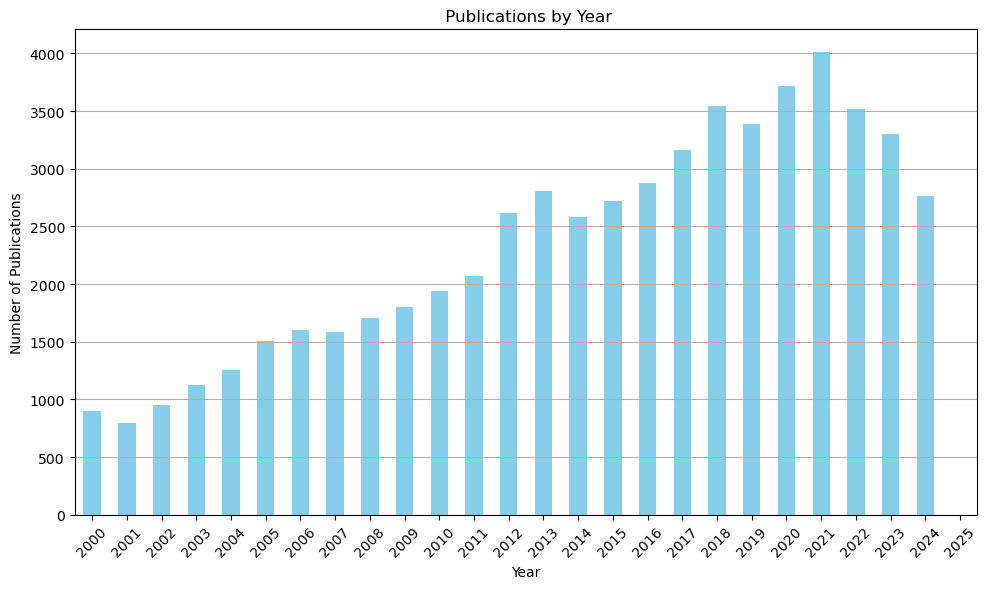

In [3]:
# Number of unique authors and publications
unique_authors = merged_data['SCOPUS_ID'].nunique()
unique_publications = merged_data['Title'].nunique()

print(f"Number of distinct authors: {unique_authors}."
      f"\nNumber of distinct publications: {unique_publications}."
      )

# See the number of publications per year
# Filter the DataFrame to only include years from {year} onwards
filtered_data = merged_data[merged_data['Year'] >= 2000]
# Group by 'Year' and count unique 'Title' values to get publications per year
unique_titles_per_year = filtered_data.groupby('Year')['Title'].nunique().reset_index()

# Plotting
unique_titles_per_year.plot(kind='bar', x='Year', y='Title', figsize=(10, 6), color='skyblue', legend=False)
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title(' Publications by Year')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

- Confirm that the data in citations column are integers and without missing values.
- Calculate number of citations per author
- Calculate number of publications per author

In [4]:
### Confirm the citations column has values that are all integers
all_integers = merged_data['Cited by'].apply(lambda x: isinstance(x, int)).all()
print(f"All values in citation column are integers: {all_integers}")

# Count the number of missing (NaN) and empty values
missing_values = merged_data['Cited by'].isna().sum() + (merged_data['Cited by'] == '').sum()
print(f"Number of missing or empty values in citation column: {missing_values}")

### Calculate the average number of citations per author
citations_per_author = merged_data.groupby('SCOPUS_ID')['Cited by'].mean()

# Check that we have correct number of values
assert len(citations_per_author) == unique_authors, "The number of unique SCOPUS_IDs should be equal to number of unique authors."

# Calculate the average of all the averages per author
average_cited_by = citations_per_author.mean()
citations_per_author.to_excel('citations_per_author.xlsx', index=False)
print(f"Average number of citations per author: {average_cited_by:.8f}")

### Count the number of publications per SCOPUS_ID (author)
publications_per_author = merged_data['SCOPUS_ID'].value_counts().reset_index()

# Rename columns for clarity
publications_per_author.columns = ['SCOPUS_ID', 'Number_of_Publications']

### Summary Statistics related to publications_per_author
total_authors = publications_per_author['SCOPUS_ID'].nunique()
pubs_info = publications_per_author['Number_of_Publications']

# Display Summary Statistics
summary_stats = {
    'Total Number of Authors': total_authors,
    'Average publications per author': pubs_info.mean(),
    'Max': pubs_info.max(),
    'Min': pubs_info.min(),
    'SD': pubs_info.std(),
    'Median': pubs_info.median(),
}

# Print the summary statistics
for key, value in summary_stats.items():
    print(f"{key}: {value}")

# Saving statistics to Excel
with pd.ExcelWriter('publications_per_author.xlsx') as writer:
    publications_per_author.to_excel(writer, sheet_name='Publication Counts', index=False)
    summary_stats_df = pd.DataFrame(list(summary_stats.items()), columns=['Statistic', 'Value'])
    summary_stats_df.to_excel(writer, sheet_name='Summary Statistics', index=False)

All values in citation column are integers: True
Number of missing or empty values in citation column: 0
Average number of citations per author: 37.82047526
Total Number of Authors: 1263
Average publications per author: 99.55898653998416
Max: 1139
Min: 1
SD: 113.26881114434349
Median: 62.0


## Calculate Q factor